In [50]:
import torch
import numpy as np
import torch.nn.functional as F

#nn.Softmax is an nn.Module, which can be initialized e.g. in the __init__ method of your model and used in the forward. 
#torch.softmax() and nn.functional.softmax are equal and I would recommend to stick to nn.functional.softmax, since it’s documented.

tokens = ["a", "dog", "is", "an", "animal"]

# Ask: how many training samples are created from this sentence (assuming tokens are words)? -> 5, including prediction of [EOS]

# The attention matrix is asymmetric because query and key matrices differ, because Wq will be different from Wk
# Good way to explain: each token (query) gets to choose how interested it is in all the other tokens, irrespective of
# how interested these other tokens are in it.
attn_scores = torch.tensor([
    [.9, .3, 0.0, .1, .0],
    [.6, 2.0, 0.1, 0.2, 1.9],
    [.0, .2, 1.0, .1, .05],
    [.05, 0.0, .1, .95, .5],
    [0.0, 1.8, 0.0, .4, 2.1],
                                ])                            

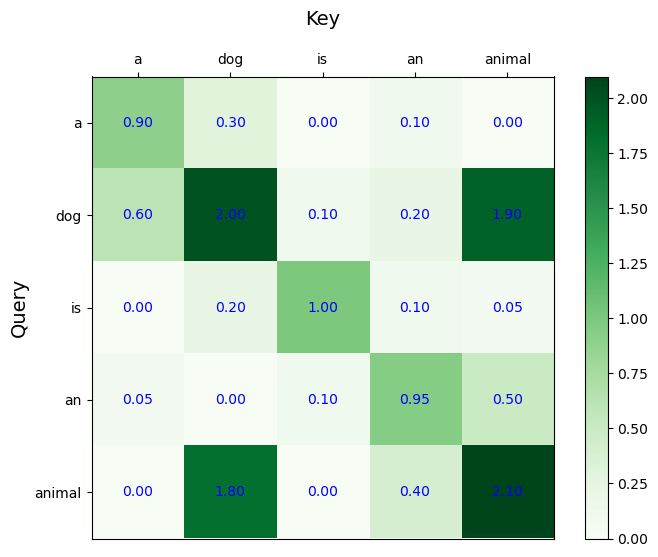

In [51]:
import matplotlib.pyplot as plt 

def attn_plot(attn_scores, tokens):
    plt.figure(figsize=(8,6))

    im = plt.imshow(attn_scores, cmap="Greens")

    plt.xticks(ticks=np.arange(attn_scores.shape[0]), labels=tokens)
    plt.yticks(ticks=np.arange(attn_scores.shape[1]), labels=tokens)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    plt.xlabel("Key", fontsize=14, labelpad=20)
    plt.gca().xaxis.set_label_position("top")
    plt.ylabel("Query", fontsize=14)
    
    for i in range(attn_scores.shape[0]):
        for j in range(attn_scores.shape[1]):
            text = plt.text(j, i, f"{attn_scores[i,j]:.2f}", ha="center", va="center", color="b")

    plt.colorbar(im)
    
    plt.show()

attn_plot(attn_scores, tokens)

As it is above, each token gets to attend to all other tokens, incl. itself -> this is good for encoder models like BERT.
We're creating a decoder though, so we need to mask all future tokens.
What we need is that the softmax result for these "cells" becomes zero, so that "zero" of the value is taken in the final
end of the formula. We can "force" softmax to be zero by putting a VERY small number in the "call" -> softmax will go to 
zero because of how it deals with this "outlier" value. We use -inf.

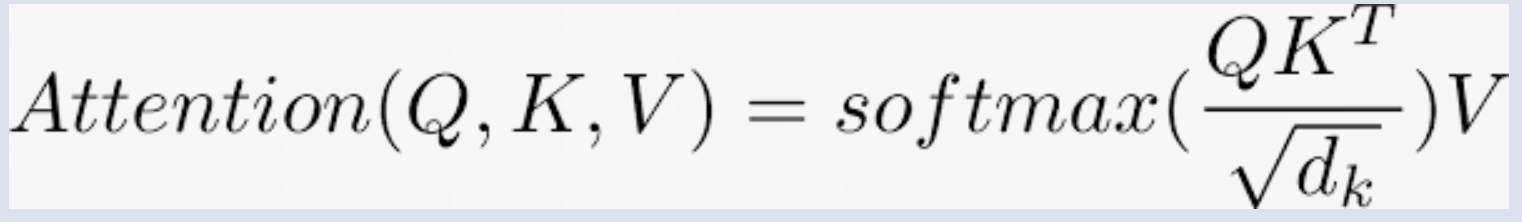

In [52]:
from PIL import Image
Image. open("./attention.png")

In [53]:
i,j = 5,5
mask = torch.ones((i,j), dtype=torch.bool)
mask

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])

In [54]:
mask = mask.triu(diagonal=1)
print(mask)


tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [55]:
attn_scores = attn_scores.masked_fill(mask, float("-inf"))
attn_scores

tensor([[0.9000,   -inf,   -inf,   -inf,   -inf],
        [0.6000, 2.0000,   -inf,   -inf,   -inf],
        [0.0000, 0.2000, 1.0000,   -inf,   -inf],
        [0.0500, 0.0000, 0.1000, 0.9500,   -inf],
        [0.0000, 1.8000, 0.0000, 0.4000, 2.1000]])

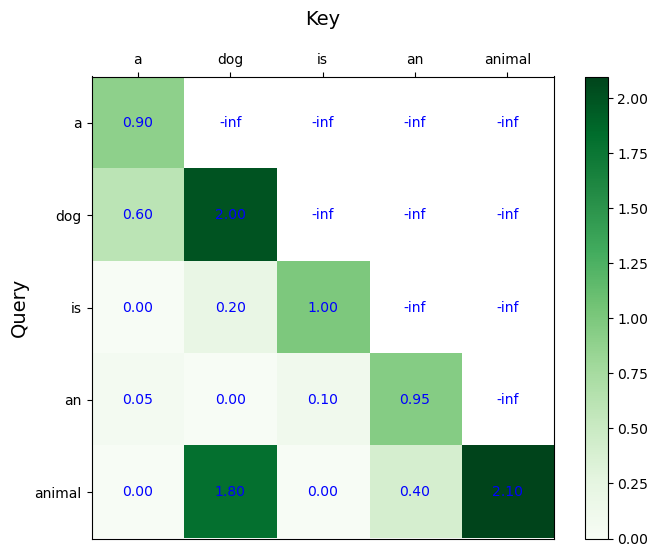

In [56]:
attn_plot(attn_scores, tokens)

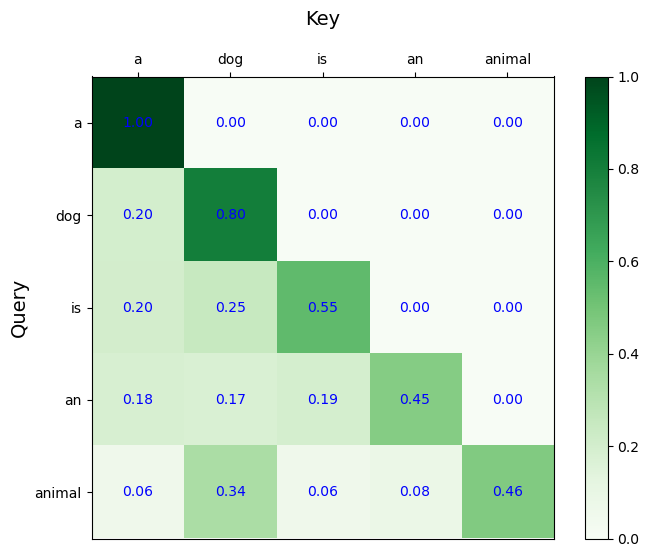

In [62]:
# Now let's apply softmax

attn_weights = F.softmax(attn_scores, dim = -1)

# dim 0 is the dimension in which you move up and down (row by row)
# dim 1 is the dimention in which you move left/righ within one row - this is the last dimension, so it's also dim(-1)

attn_plot(attn_weights, tokens)

# Attention weights == softmaxed attention scores



How to talk to this: "is interested in"
- a only sees a so is 100% intersted in a
- dog see as dog, is a bit interested in a, but 80% in dog
- is is still mostly intersted in itself
- ...
- animal is interted in itself but also in dog

In [ ]:
# Now these weights determine how much weight each value vector will get, including the value vector for the query itself
# Let's do this for the last row, so to predict [EOS]